In [1]:
import torch
import einops

import matplotlib.pyplot as plt
import itertools

from utils.config import *
from utils.masking import KumaraswamyMasking
from utils.model import MaskedPredictor
from utils.loss_fn import f_kernel_crps

from omegaconf import OmegaConf
from dataclasses import replace

In [80]:
cfg_file = OmegaConf.load('mae.yaml')
config = MTMConfig.from_omegaconf(cfg_file['defaults'])

In [81]:
N = config.world.num_tokens
S = 32
B = 4096
config.world.batch_size = B
a,b = 0.005, 0.995

In [174]:

# FRAME-WISE BERNOULLI PRIOR
class KumaraswamyMasking(torch.nn.Module):
    '''Kumaraswamy Masking strategy with numerical stable methods courtesy of Wasserman et al 2024'''
    def __init__(self, world: WorldConfig, objective: ObjectiveConfig):
        super().__init__()
        # configs
        self.world = world
        self.objective = objective

        assert objective.c1 > 0. and objective.c0 > 0., 'invalid concentration'
        assert all([d in world.flat_token_pattern for d in objective.event_dims]), 'event dims not in token pattern'

        # Calculate the total size of the event dimensions
        self.num_events = prod([world.token_sizes[d] for d in objective.event_dims])
        
        # Format the event pattern for einops
        self.event_pattern = f'({" ".join(objective.event_dims)})'
        
        # Register hyperparameters as buffers for device consistency
        self.register_buffer("c1", torch.tensor(objective.c1, requires_grad=False))
        self.register_buffer("c0", torch.tensor(objective.c0, requires_grad=False))
        
        # Epsilon ensures 't' is not exactly 0 or 1, which causes numerical instability
        self.epsilon = objective.epsilon
    
    # Kumaraswamy with log1mexp
    @staticmethod
    def log1mexp(t: torch.FloatTensor): #numerically stable log(1 - e**x)
        return torch.where(
        t < -0.69314718, #~ -log2
        torch.log1p(-torch.exp(t)), 
        torch.log(-torch.expm1(t))
    )

    def quantile_dt(self, t: torch.Tensor): # time derivative of the quantile function
        #(1 - t)**((1 - c0) / c0) * (1 - (1 - t)**(1 / c0))**((1 - c1) / c1) / (c1 * c0)
        log_1_minus_t = torch.log1p(-t) # 1 - t
        log_constant = -self.c1.log() - self.c0.log() # 1 / c0 * c1
        log_outer = log_1_minus_t * ((1 - self.c0) / self.c0) # (1 - t)**(1-c0)/c0
        log_inner = ((1 - self.c1) / self.c1) * self.log1mexp(log_1_minus_t / self.c0)
        return torch.exp(log_constant + log_inner + log_outer)

    def quantile(self, t: torch.Tensor): # (1 - (1 - t)**(1 / c0))**(1 / c1)
        return torch.exp(self.log1mexp(torch.log1p(-t) / self.c0) / self.c1)
    
    def cdf(self, t: torch.Tensor): # 1 - (1 - t**c1)**c0
        return -torch.expm1(self.c0 * self.log1mexp(self.c1 * t.log()))
    
    # Masking
    def sample_prior(self, shape: tuple, rng: torch.Generator = None):
        if self.objective.stratify:
            t = torch.rand(shape[:-1] + (1,) + (self.num_events,), device=self.c1.device, generator=rng)
            t = (t + torch.linspace(0, 1, shape[-1]).view(-1, 1)) % 1
        else:
            t = torch.rand(shape + (self.num_events,), device=self.c1.device, generator=rng)
        t = t * (1.0 - 2.0 * self.epsilon) + self.epsilon
        return t
    
    def schedule(self, t: torch.Tensor):
        # shared terms
        log_1_minus_t = torch.log1p(-t)
        log_exp_inner = self.log1mexp(log_1_minus_t / self.c0) / self.c1
        # individual terms
        log_constant = -self.c1.log() - self.c0.log()
        log_outer = ((1 - self.c0) / self.c0) * log_1_minus_t
        log_inner = (1 - self.c1) * log_exp_inner
        # combine
        quantile = torch.exp(log_exp_inner)
        quantile_dt = torch.exp(log_constant + log_inner + log_outer)
        return quantile, quantile_dt

    def expand_events(self, *args):
        return einops.repeat(
            [*args],
            f'args ... {self.event_pattern} -> args ... {self.world.flat_token_pattern}', 
            **self.world.token_sizes
            )

    def sample_masks(self, rates: torch.Tensor, rng: torch.Generator = None):
        return rates > torch.rand(rates.shape, device=self.c1.device, generator=rng)

    # Forward
    def forward(self, shape: tuple, rng: torch.Generator = None) -> tuple[torch.BoolTensor, torch.FloatTensor]:
        t = self.sample_prior(shape, rng=rng)
        t = t.sort().values.round(decimals=2)
        if self.objective.progressive: t = t.sort(0, descending = True).values
        rates, weights = self.schedule(t)
        rates, weights = self.expand_events(rates, weights)
        masks = self.sample_masks(rates, rng=rng)
        return masks, weights

In [315]:
obj_cfg=replace(config.objective, c1=1.5, c0=0.5, epsilon=0.05)
km = KumaraswamyMasking(config.world,obj_cfg)

m, w = km((B//S,S))

In [316]:
ww = einops.reduce(w, f's b {config.world.flat_token_pattern} -> (s b) t', **config.world.token_sizes, reduction='mean')
mm = einops.reduce(m.float(), f's b {config.world.flat_token_pattern} -> (s b) t', **config.world.token_sizes, reduction='mean')

In [317]:
mm

tensor([[0.6062, 0.8403, 0.8639, 0.9701, 0.9750, 0.9965],
        [0.6444, 0.8535, 0.8819, 0.9750, 0.9819, 0.9993],
        [0.2868, 0.6507, 0.8646, 0.8972, 0.9812, 0.9875],
        ...,
        [0.2535, 0.4340, 0.6549, 0.7840, 0.9389, 0.9812],
        [0.3368, 0.5188, 0.7056, 0.8062, 0.9646, 0.9840],
        [0.3722, 0.5208, 0.7194, 0.8208, 0.9597, 0.9903]])

In [318]:
print(ww.max(), ww.min())

tensor(2.7521) tensor(0.0667)


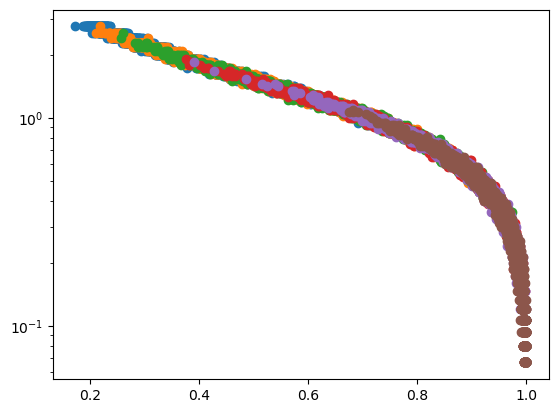

In [319]:
plt.semilogy(mm, ww, "o")

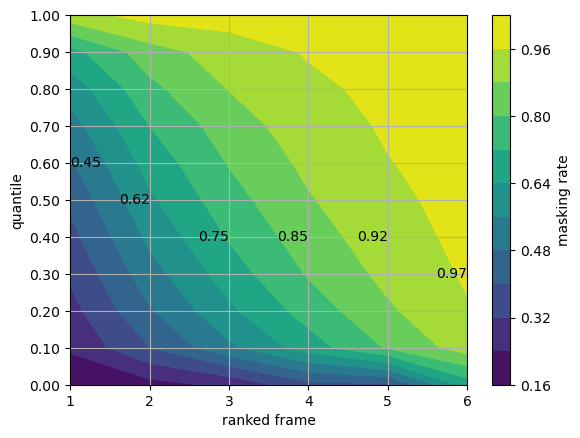

In [320]:
qs = torch.linspace(0, 1, 11)
data = torch.quantile(mm, qs, dim=0)
means = mm.mean(dim=0)

plt.contourf(data, levels = 10)
plt.yticks(torch.arange(len(qs)),[f"{q:.2f}" for q in qs])
plt.xticks(torch.arange(6), list(range(1, 7)))
plt.xlabel("ranked frame")
plt.ylabel("quantile")
plt.colorbar(label="masking rate")

# For each column: find quantile row closest to the mean
for x, mu in enumerate(means):
    col = data[:, x]                         # quantile values for this column
    idx = torch.argmin(torch.abs(col - mu))   # closest quantile row

    plt.text(
        x,
        idx.item(),
        f"{mu:.2f}",
        ha="left" if x == 0 else "right",
        va="center",
    )

plt.grid()
plt.show()

In [321]:
full_drop_rate = (mm == 1.0).float().mean(0)
print(f'expected  full frame dropped per rank: {(full_drop_rate * 100).long()}%')
print(f'expected  full frames dropped total: {(full_drop_rate.mean() * 100).long()}%')

expected  full frame dropped per rank: tensor([0, 0, 0, 0, 0, 0])%
expected  full frames dropped total: 0%


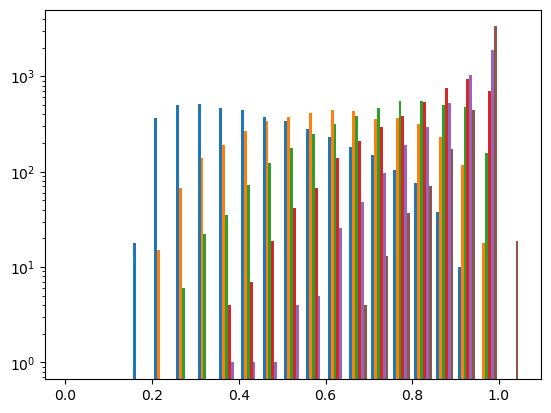

In [322]:
_=plt.hist(mm, bins = torch.linspace(0,1.05, 22), log=True)

In [166]:
special_points = {
    "linear":     (1.0, 1.0),
    "jeffreys":    (0.5, 0.5),
    'sine': (0.9, 0.5),
    'binomial 0.1': (4., 0.75),
    'binomial 0.3': (8., 0.5),
    'dirichlet 0.5':(2.5, 0.5),
}

In [ ]:
c1s = [0.9, 1.25, 2.5,  8]
c0s = [0.25, 0.4, 0.5]
sps={}
fig, axs = plt.subplots(len(c1s),len(c0s),figsize=(16,16), sharex = True, sharey=True)
for i,c1 in enumerate(c1s):
    for j,c0 in enumerate(c0s):
        sps[f'{c1, c0}'] = (c1, c0)
        obj_cfg = replace(config.objective, c1=c1,c0=c0)
        dist = KumaraswamyMasking(config.world, obj_cfg)
        m, _ = dist((B//S, S))
        mm = einops.reduce(m.float(), f's b {config.world.flat_token_pattern} -> (s b) t', **config.world.token_sizes, reduction='mean').sort(dim=-1).values
        full_drop_rate = (mm == 1.0).float().mean(0)
        axs[i, j].plot(full_drop_rate, 'o-')
        axs[i,j].set_title(f'{c1, c0}')

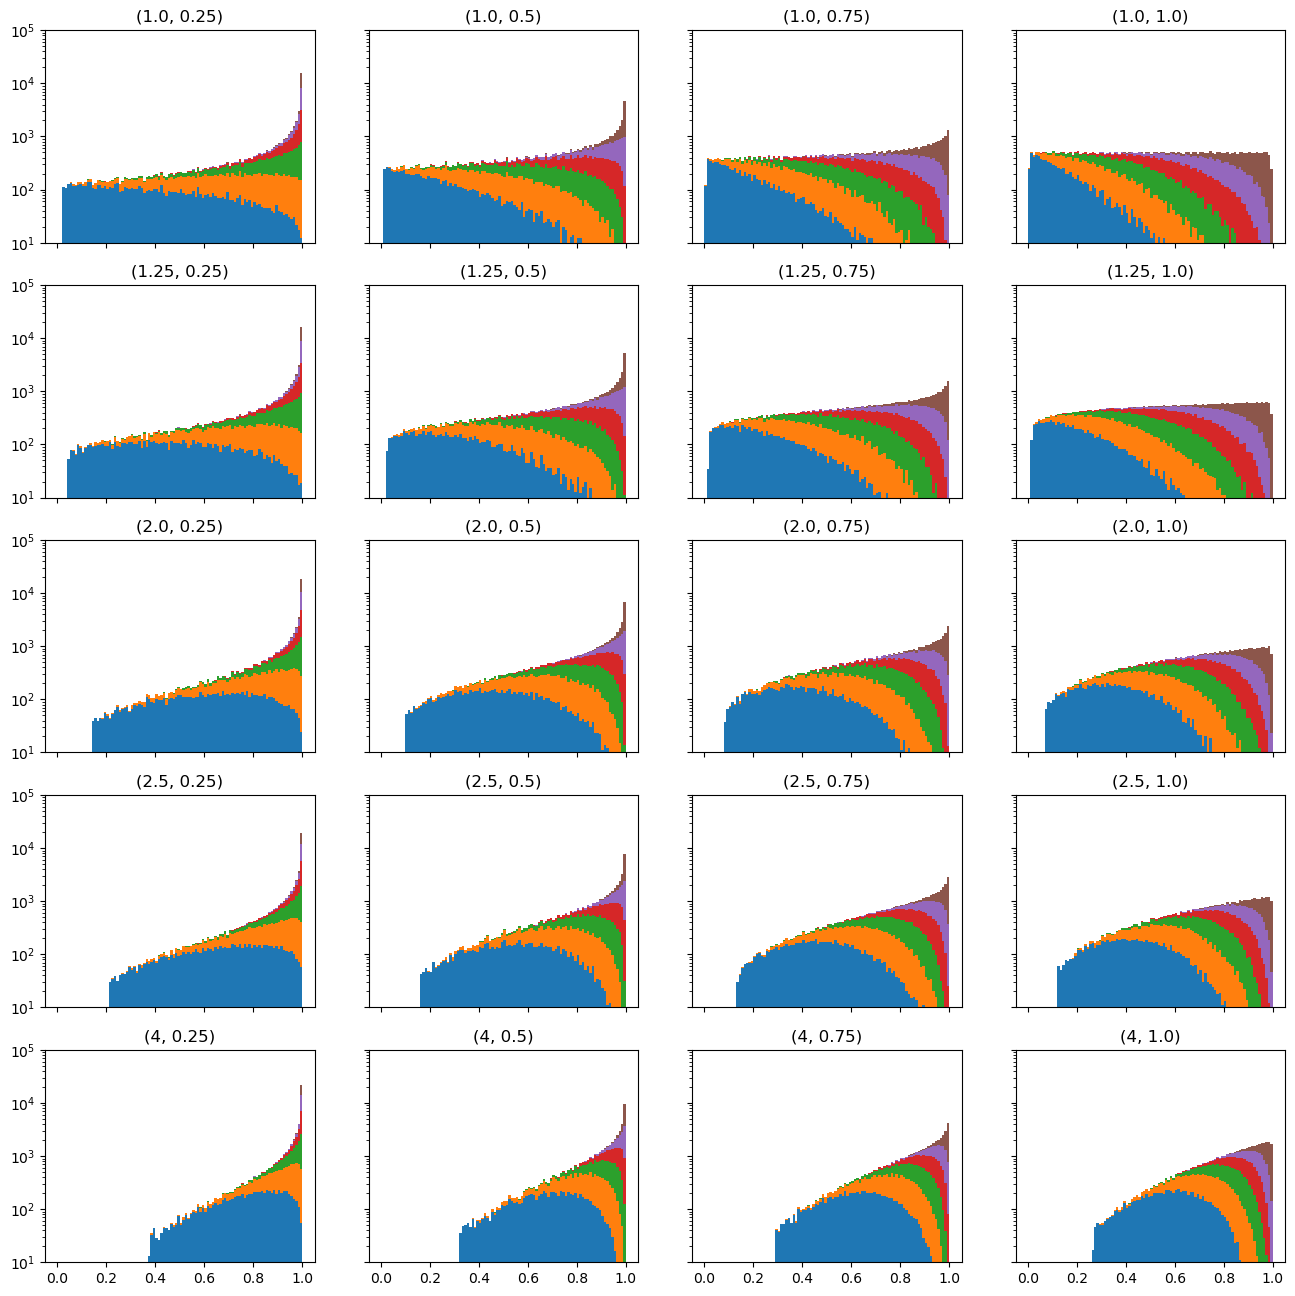

In [61]:
c1s = [1., 1.25, 2., 2.5,4]
c0s = [0.25, 0.5, 0.75, 1.]
sps={}
fig, axs = plt.subplots(len(c1s),len(c0s),figsize=(16,16), sharex = True, sharey=True)
plt.yscale('log')
plt.ylim(1e1, 1e5)
for i,c1 in enumerate(c1s):
    for j,c0 in enumerate(c0s):
        sps[f'{c1, c0}'] = (c1, c0)
        obj_cfg = replace(config.objective, c1=c1,c0=c0)
        dist = KumaraswamyMasking(config.world, obj_cfg)
        t = dist.sample_prior((B//S, S))
        t = einops.rearrange(t,'s b n -> (s b) n')
        r = dist.quantile(t).sort(dim=-1).values
        axs[i, j].hist(r, bins = torch.linspace(0, 1, 101), histtype = 'barstacked')
        axs[i,j].set_title(f'{c1, c0}')

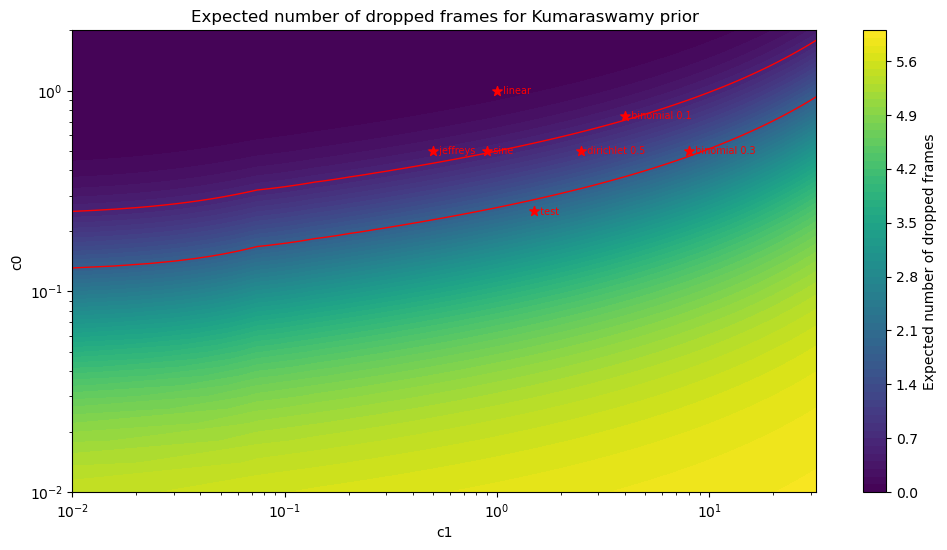

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# parameter grids
tau = 0.99
s = 6

# mesh
C1, C0 = np.meshgrid(np.linspace(0.01, 32, 500), np.linspace(0.01, 2, 500), indexing="ij")

# survival probability P(X > tau)
Z = s * (1 - tau**C1)**C0

plt.figure(figsize=(12, 6))
plt.contourf(C1, C0, Z, levels=np.linspace(0, s, s * 10 + 1))
plt.colorbar(label=f"Expected number of dropped frames")
plt.contour(C1, C0, Z, levels=[0.6, 1.8], colors="red", linewidths=1)
plt.xlabel("c1")
plt.ylabel("c0")
plt.xscale('log')
plt.yscale('log')

plt.title(f"Expected number of dropped frames for Kumaraswamy prior")
# special parameter points
special_points = {
    "linear":     (1.0, 1.0),
    "jeffreys":    (0.5, 0.5),
    'sine': (0.9, 0.5),
    'binomial 0.1': (4., 0.75),
    'binomial 0.3': (8., 0.5),
    'dirichlet 0.5':(2.5, 0.5),
    "test": (1.5, 0.25)
}

for name, (c1_val, c0_val) in special_points.items():
    plt.scatter(c1_val, c0_val, marker="*", color="red", s=50, zorder=10)
    plt.text(c1_val, c0_val, f"  {name}", color="red", va="center", ha="left", fontsize=7)

plt.show()


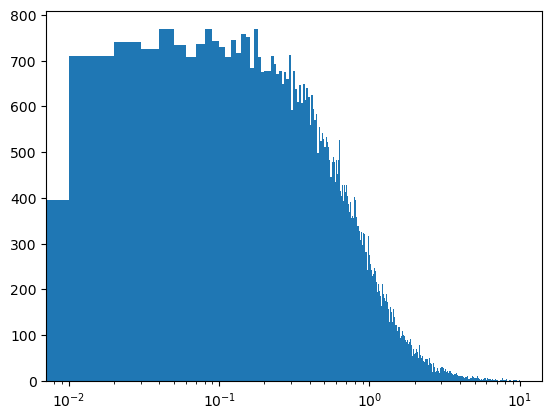

In [ ]:
_=plt.hist(w.flatten(), bins = torch.linspace(0,10,1001))
plt.xscale('log')

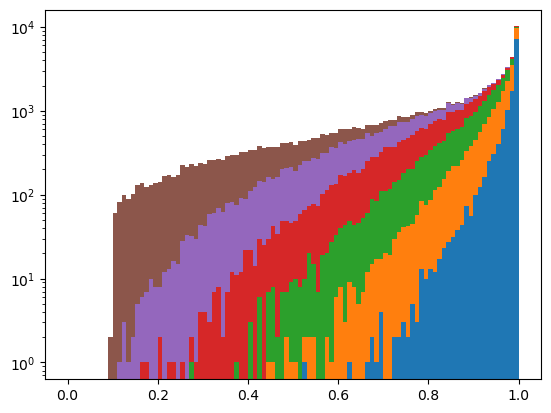

In [ ]:
_=plt.hist(r.flatten(1).T, bins = torch.linspace(0,1,101), histtype='barstacked')
plt.yscale('log')

In [12]:
dt_kumaraswamy = lambda t, c1,c0: (1 - t)**((1 - c0) / c0) * (1 - (1 - t)**(1 / c0))**((1 - c1) / c1) / (c1 * c0)
quantile__kumaraswamy = lambda t, c1,c0: (1 - (1 - t)**(1 / c0))**(1 / c1)
cdf_kumaraswamy = lambda t, c1,c0: 1 - (1 - t**c1)**c0

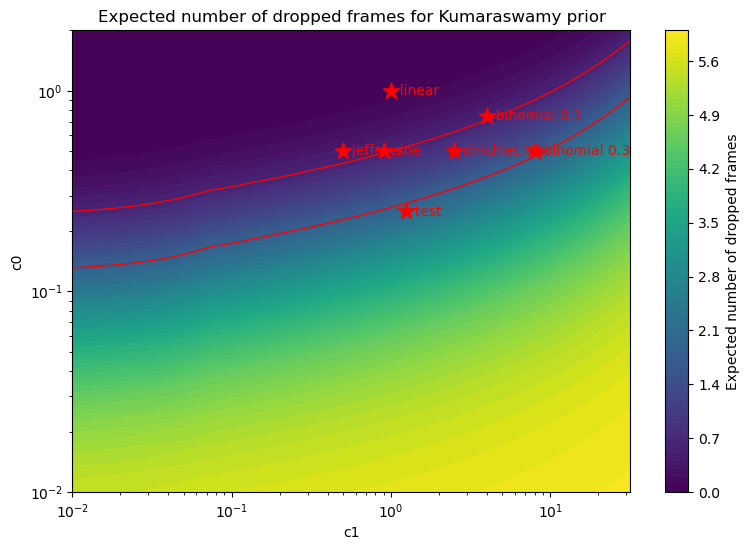

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# parameter grids
#c1s = np.array([0.1, 0.5, 1., 2., 4., 8., 16., 32])
#c0s = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1., 2.])
c1s = np.linspace(0.01, 32, 500)
c0s = np.linspace(0.01, 2, 500)
tau = 0.99
s = 6

# mesh
C1, C0 = np.meshgrid(c1s, c0s, indexing="ij")

# survival probability P(X > tau)
Z = s * (1 - tau**C1)**C0

plt.figure(figsize=(9, 6))
plt.contourf(C1, C0, Z, levels=np.linspace(0, s, s * 10 + 1))
plt.colorbar(label=f"Expected number of dropped frames")
plt.contour(C1, C0, Z, levels=[0.6, 1.8], colors="red", linewidths=1)
plt.xlabel("c1")
plt.ylabel("c0")
plt.xscale('log')
plt.yscale('log')

plt.title(f"Expected number of dropped frames for Kumaraswamy prior")
# special parameter points
special_points = {
    "linear":     (1.0, 1.0),
    "jeffreys":    (0.5, 0.5),
    'sine': (0.9, 0.5),
    'binomial 0.1': (4., 0.75),
    'binomial 0.3': (8., 0.5),
    'dirichlet 0.5':(2.5, 0.5),
    "test": (1.25, 0.25)
}

for name, (c1_val, c0_val) in special_points.items():
    plt.scatter(c1_val, c0_val, marker="*", color="red", s=150, zorder=10)
    plt.text(c1_val, c0_val, f"  {name}", color="red", va="center", ha="left")

plt.show()


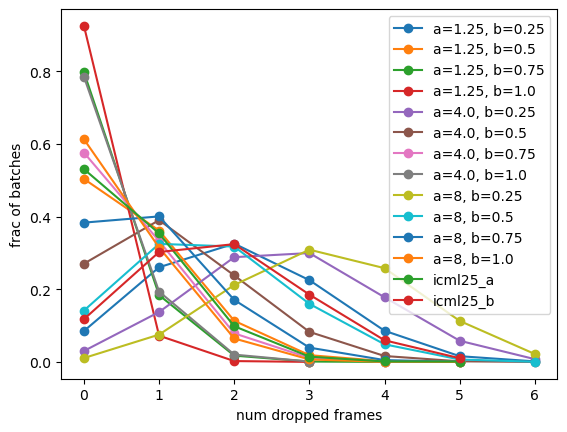

In [199]:
for a,b in itertools.product([1.25, 4.,8],[0.25, 0.5,0.75, 1.]):
    beta = torch.distributions.Kumaraswamy(a,b).sample((B,S)).sort().values
    plt.plot((beta > 0.99).float().sum(1).long().bincount() / B, "o-", label=f"a={a}, b={b}")
plt.plot(get_pmf(6,0.1), "o-", label="icml25_a")
plt.plot(get_pmf(6,0.3), "o-", label="icml25_b")

plt.xlabel("num dropped frames")
plt.ylabel("frac of batches")
plt.legend()

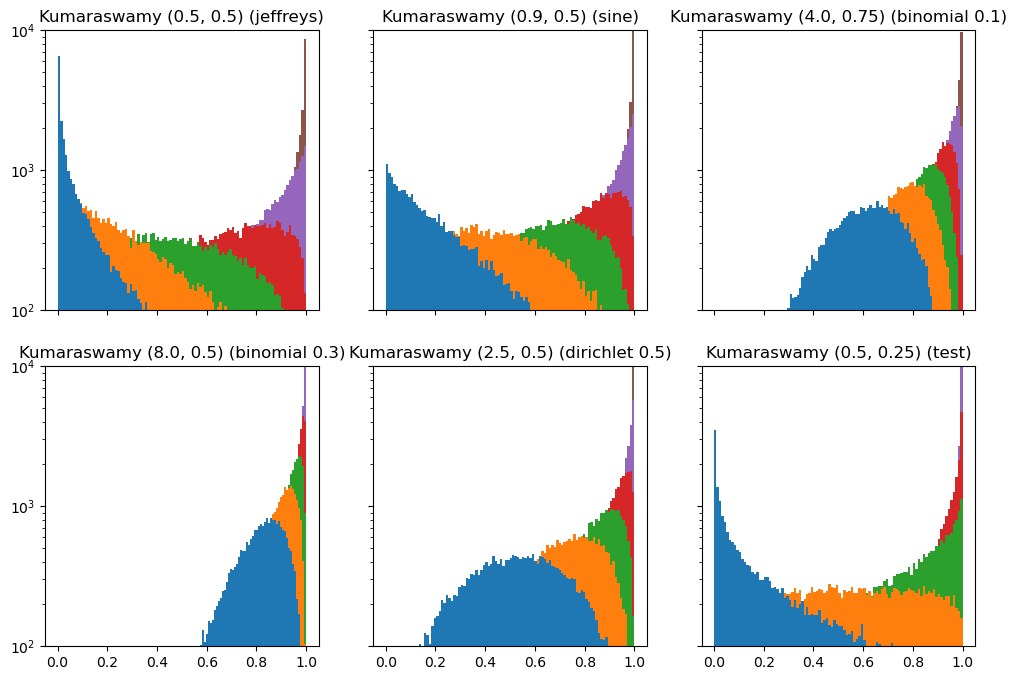

In [200]:
fig, axs = plt.subplots(2,3,figsize=(12,8), sharex=True, sharey=True)
for i, (label, (c1, c0)) in enumerate(special_points.items()):
    plt.sca(axs.flatten()[i])
    dist = torch.distributions.Kumaraswamy(c1, c0).sample((B, S)).sort().values
    plt.hist(dist, histtype="stepfilled", bins = 100)
    plt.title(f"Kumaraswamy {c1, c0} ({label})")
plt.yscale("log")
plt.ylim(1e2, 1e4)
plt.show()


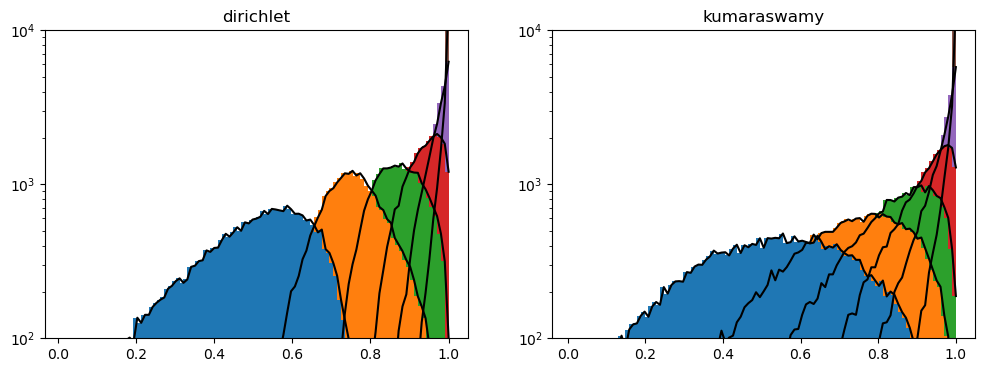

In [195]:
plt.figure(figsize=(12,4))
plt.subplot(121)
d2 = torch.distributions.Dirichlet(torch.full((6,), 0.5)).sample((B,)).sort(descending=True).values 
a,b,c=plt.hist(1 - d2, histtype="stepfilled", bins = 100)
plt.plot(b[1:],a.T, c="black")
plt.yscale("log")
plt.ylim(1e2,1e4)

plt.title("dirichlet")
plt.subplot(122)
dist = torch.distributions.Kumaraswamy(2.5, 0.5).sample((B, S)).sort().values 
a,b,c=plt.hist(dist, histtype="stepfilled", bins = 100) 
plt.plot(b[1:],a.T, c="black")
plt.yscale("log")
plt.ylim(1e2,1e4)
plt.title("kumaraswamy")
plt.show()

In [4]:
t = torch.rand((S, B))
t = (t + torch.linspace(0,1,B).view(1,-1))%1
t=t.sort(dim=0, descending=True).values

rates = torch.sin(torch.pi * t * 0.5)
#rates = rates.round(decimals=2)
#rates = 0.5 - 0.5 * torch.cos(torch.pi * t)
t = (b - a) * t + a
weights = torch.sin(torch.pi * t * 0.5) * torch.cos(torch.pi * t * 0.5) * torch.pi

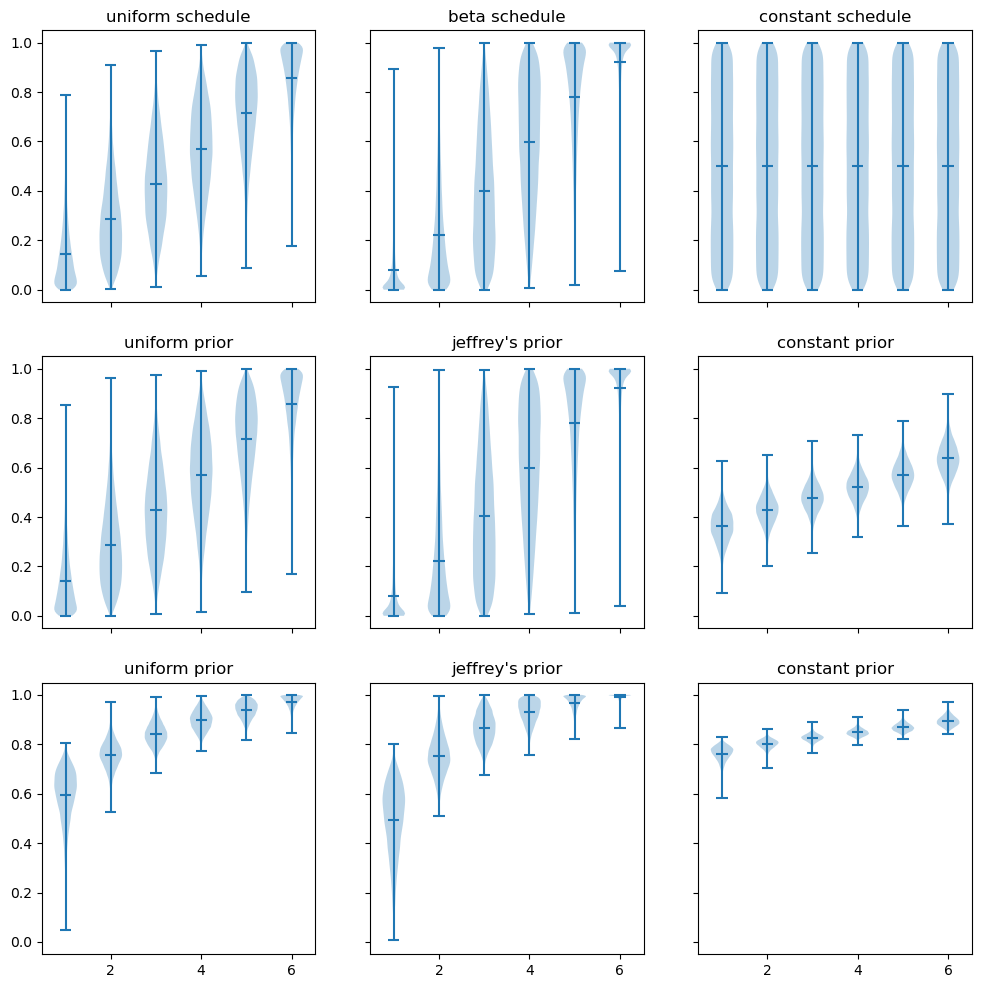

In [5]:

fig, axs = plt.subplots(3,3,figsize=(12,12), sharex=True, sharey=True)
t = torch.rand((B, S)).sort(dim=1).values
t3 = torch.rand((B, 1)).expand(-1, S)
t2 = 0.5 - 0.5 * torch.cos(torch.pi * t)
t4 = torch.sin(torch.pi*t*0.5)
axs[0,0].violinplot(t, showmeans=True, showextrema=True)
axs[0,0].set_title('uniform schedule')
axs[0,1].violinplot(t2, showmeans=True, showextrema=True)
axs[0,1].set_title("beta schedule")
axs[0,2].violinplot(t3, showmeans=True, showextrema=True)
axs[0,2].set_title("constant schedule")
b1 = torch.distributions.Beta(1.0, 1.0).sample((B,S)).sort().values
b2 = torch.distributions.Beta(0.5, 0.5).sample((B,S)).sort().values
b3 = torch.distributions.Beta(10., 10.0).sample((B,S)).sort().values
axs[1,0].violinplot(b1, showmeans=True, showextrema=True)
axs[1,0].set_title('uniform prior')
axs[1,1].violinplot(b2, showmeans=True, showextrema=True)
axs[1,1].set_title("jeffrey's prior")
axs[1,2].violinplot(b3, showmeans=True, showextrema=True)
axs[1,2].set_title("constant prior")
d1 = torch.distributions.Dirichlet(torch.full((6,), 1.0)).sample((B,)).sort(descending=True).values
d2 = torch.distributions.Dirichlet(torch.full((6,), 0.5)).sample((B,)).sort(descending=True).values
d3 = torch.distributions.Dirichlet(torch.full((6,), 10.0)).sample((B,)).sort(descending=True).values

axs[2,0].violinplot(1 - d1, showmeans=True, showextrema=True)
axs[2,0].set_title('uniform prior')
axs[2,1].violinplot(1 - d2, showmeans=True, showextrema=True)
axs[2,1].set_title("jeffrey's prior")
axs[2,2].violinplot(1 - d3, showmeans=True, showextrema=True)
axs[2,2].set_title("constant prior")
plt.show()

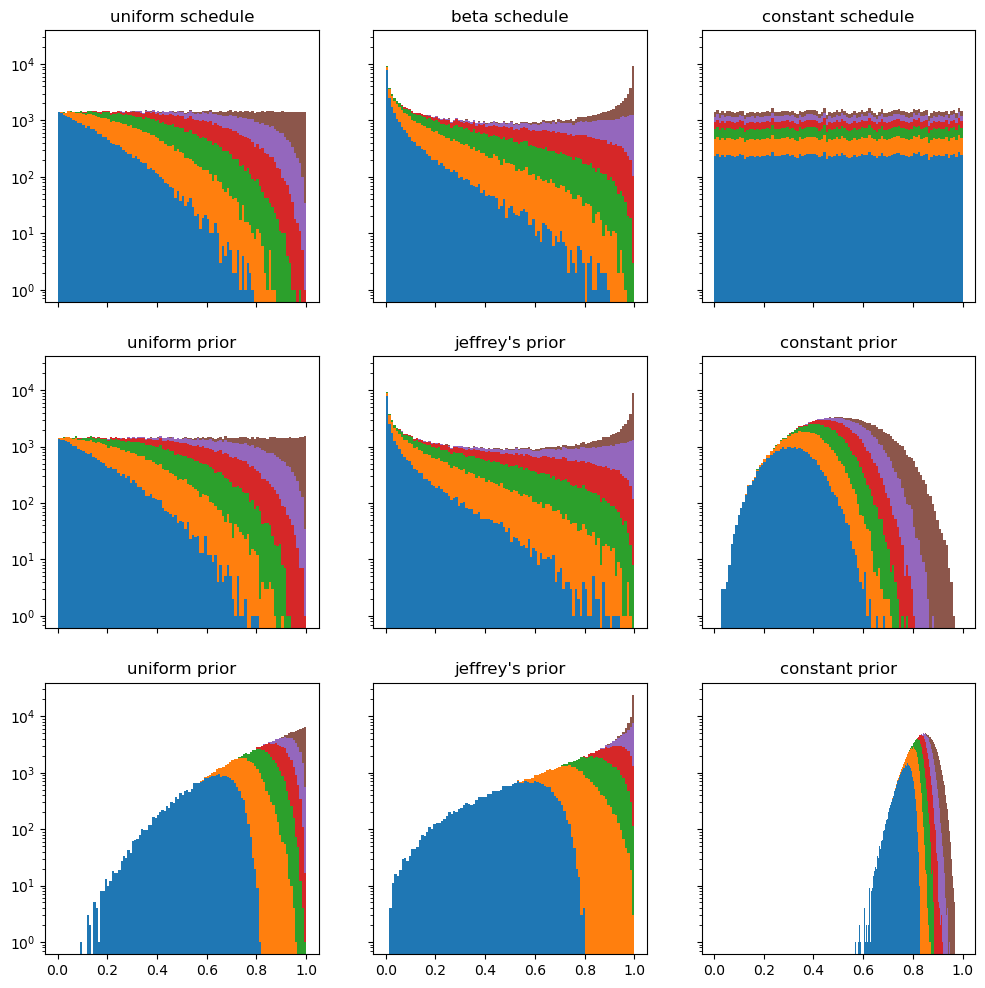

In [6]:

fig, axs = plt.subplots(3,3,figsize=(12,12), sharex=True, sharey=True)
t = torch.rand((B, S)).sort(dim=1).values
t3 = torch.rand((B, 1)).expand(-1, S)
t2 = 0.5 - 0.5 * torch.cos(torch.pi * t)
t4 = torch.sin(torch.pi*t*0.5)
axs[0,0].hist(t, histtype='barstacked', bins=100)
axs[0,0].set_title('uniform schedule')
axs[0,1].hist(t2, histtype='barstacked', bins=100)
axs[0,1].set_title("beta schedule")
axs[0,2].hist(t3, histtype='barstacked', bins=100)
axs[0,2].set_title("constant schedule")
b1 = torch.distributions.Beta(1.0, 1.0).sample((B,S)).sort().values
b2 = torch.distributions.Beta(0.5, 0.5).sample((B,S)).sort().values
b3 = torch.distributions.Beta(5., 5.0).sample((B,S)).sort().values
axs[1,0].hist(b1, histtype='barstacked', bins=100)
axs[1,0].set_title('uniform prior')
axs[1,1].hist(b2, histtype='barstacked', bins=100)
axs[1,1].set_title("jeffrey's prior")
axs[1,2].hist(b3, histtype='barstacked', bins=100)
axs[1,2].set_title("constant prior")
d1 = torch.distributions.Dirichlet(torch.full((6,), 1.0)).sample((B,)).sort(descending=True).values
d2 = torch.distributions.Dirichlet(torch.full((6,), 0.5)).sample((B,)).sort(descending=True).values
d3 = torch.distributions.Dirichlet(torch.full((6,), 10.0)).sample((B,)).sort(descending=True).values

axs[2,0].hist(1 - d1, histtype='barstacked', bins=100)
axs[2,0].set_title('uniform prior')
axs[2,1].hist(1 - d2, histtype='barstacked', bins=100)
axs[2,1].set_title("jeffrey's prior")
axs[2,2].hist(1 - d3, histtype='barstacked', bins=100)
axs[2,2].set_title("constant prior")
plt.yscale("log")
plt.show()

Text(0.5, 0.98, 'frame-wise masking rates for different schedules')

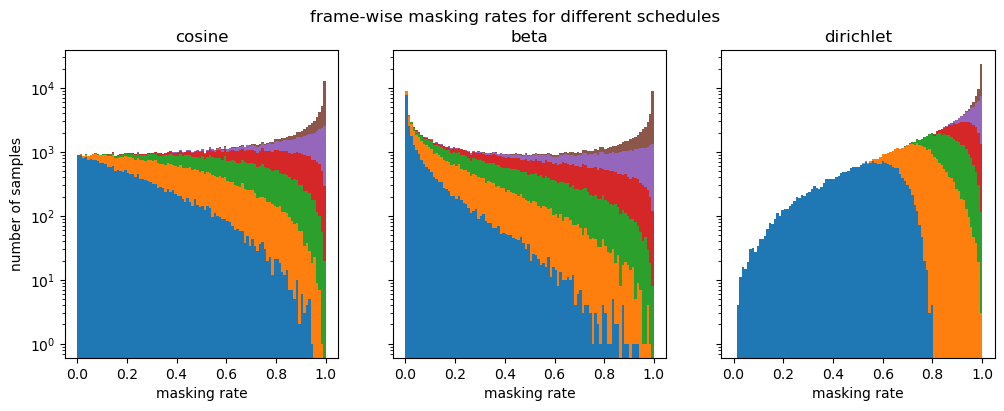

In [7]:
fig, axs = plt.subplots(1,3,figsize=(12,4), sharey=True, sharex=True)
axs[0].hist(torch.sin(torch.pi * t * 0.5), bins=100, histtype='barstacked')
axs[0].set_title("cosine")
axs[0].set_xlabel('masking rate')
axs[0].set_ylabel('number of samples')
axs[2].hist(1 - d2, bins = 100, histtype='barstacked')
axs[2].set_title('dirichlet')
axs[2].set_xlabel('masking rate')
axs[1].hist(b2, bins = 100, histtype='barstacked')
axs[1].set_title('beta')
axs[1].set_xlabel('masking rate')
plt.yscale('log')
plt.suptitle('frame-wise masking rates for different schedules')

In [8]:

d1 = torch.distributions.Dirichlet(torch.full((6,), 1.0)).sample((B,)).sort(descending=False).values
d2 = torch.distributions.Dirichlet(torch.full((6,), 0.5)).sample((B,)).sort(descending=False).values
d3 = torch.distributions.Dirichlet(torch.full((6,), 10.0)).sample((B,)).sort(descending=False).values

Text(0.5, 0.98, 'frame-wise masking rates for different schedules')

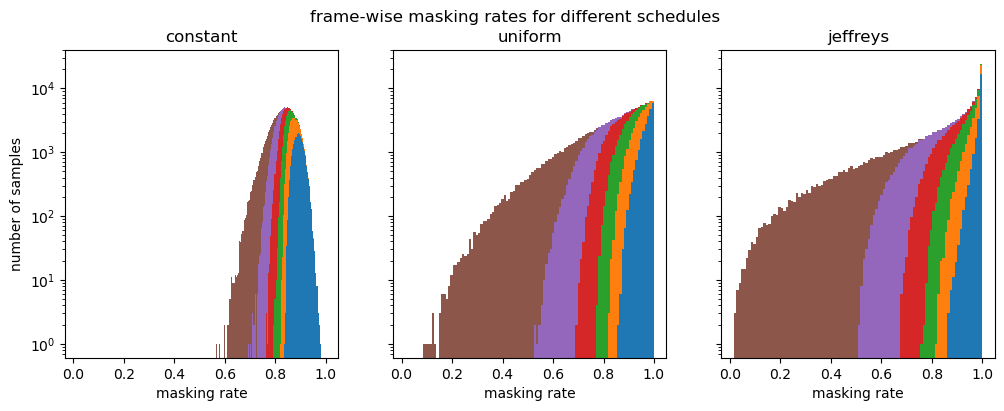

In [9]:
fig, axs = plt.subplots(1,3,figsize=(12,4), sharey=True, sharex=True)
axs[0].hist(1-d3, bins=100, histtype='barstacked')
axs[0].set_title("constant")
axs[0].set_xlabel('masking rate')
axs[0].set_ylabel('number of samples')
axs[2].hist(1 - d2, bins = 100, histtype='barstacked')
axs[2].set_title('jeffreys')
axs[2].set_xlabel('masking rate')
axs[1].hist(1-d1, bins = 100, histtype='barstacked')
axs[1].set_title('uniform')
axs[1].set_xlabel('masking rate')
plt.yscale('log')
plt.suptitle('frame-wise masking rates for different schedules')

In [10]:
dd=torch.distributions.Dirichlet(torch.full((6,), 0.5)).sample((B,)).sort().values


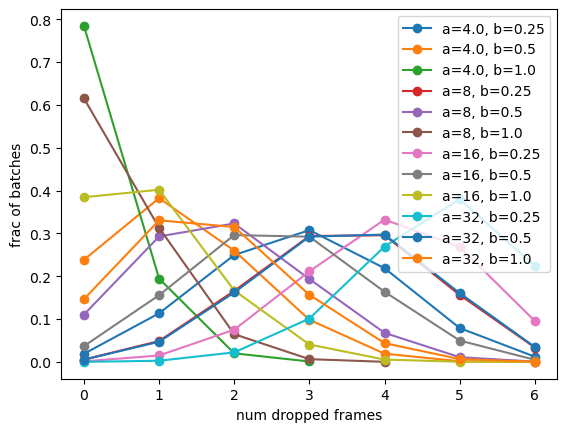

In [ ]:
from itertools import product
for a,b in product([4.,8, 16,32],[0.25,0.5,1.]):
    beta = torch.distributions.Beta(a,b).sample((B,S)).sort().values
    plt.plot((beta > 0.99).float().sum(1).long().bincount() / B, "o-", label=f"a={a}, b={b}")
plt.xlabel("num dropped frames")
plt.ylabel("frac of batches")
plt.legend()

In [191]:
k1 = torch.distributions.Kumaraswamy(1., 1.).sample((B,S)).sort().values
k2 = torch.distributions.Kumaraswamy(0.5, 0.5).sample((B,S)).sort().values
k3 = torch.distributions.Kumaraswamy(8., 0.75).sample((B,S)).sort().values
k4 = torch.distributions.Kumaraswamy(2., 0.5).sample((B,S)).sort().values

k5 = torch.distributions.Kumaraswamy(4., 1.).sample((B,S)).sort().values
k6 = torch.distributions.Kumaraswamy(4., 2.).sample((B,S)).sort().values
k7 = torch.distributions.Kumaraswamy(2., 0.5).sample((B,S)).sort().values
k8 = torch.distributions.Kumaraswamy(2., 1).sample((B,S)).sort().values

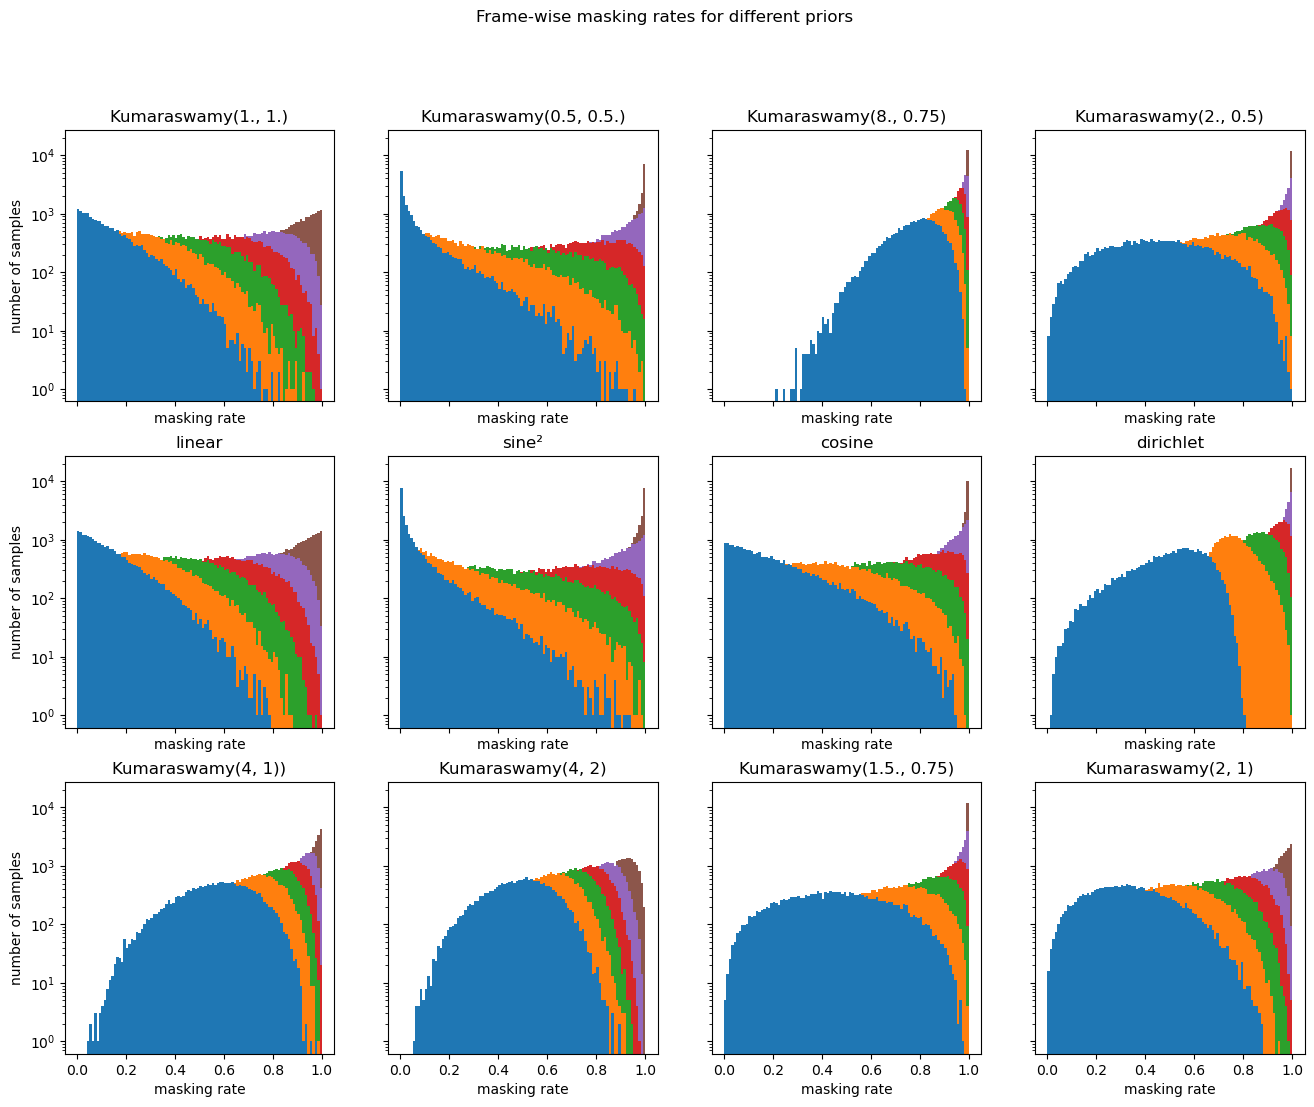

In [192]:
fig, axs = plt.subplots(3,4,figsize=(16,12), sharey=True, sharex=True)
axs[0,0].hist(k1, bins=ts, histtype='stepfilled')
axs[0,0].set_xlabel('masking rate')
axs[0,0].set_ylabel('number of samples')
axs[0,0].set_title('Kumaraswamy(1., 1.)')
axs[0,1].hist(k2, bins = ts, histtype='stepfilled')
axs[0,1].set_xlabel('masking rate')
axs[0,1].set_title('Kumaraswamy(0.5, 0.5.)')
axs[0,2].hist(k3, bins = ts, histtype='stepfilled')
axs[0,2].set_xlabel('masking rate')
axs[0,2].set_title('Kumaraswamy(8., 0.75)')
axs[0,3].hist(k4, bins = ts, histtype='stepfilled')
axs[0,3].set_xlabel('masking rate')
axs[0,3].set_title('Kumaraswamy(2., 0.5)')
axs[2,0].hist(k5, bins=ts, histtype='stepfilled')
axs[2,0].set_xlabel('masking rate')
axs[2,0].set_ylabel('number of samples')
axs[2,0].set_title('Kumaraswamy(4, 1))')
axs[2,1].hist(k6, bins = ts, histtype='stepfilled')
axs[2,1].set_xlabel('masking rate')
axs[2,1].set_title('Kumaraswamy(4, 2)')
axs[2,2].hist(k7, bins = ts, histtype='stepfilled')
axs[2,2].set_xlabel('masking rate')
axs[2,2].set_title('Kumaraswamy(1.5., 0.75)')
axs[2,3].hist(k8, bins = ts, histtype='stepfilled')
axs[2,3].set_xlabel('masking rate')
axs[2,3].set_title('Kumaraswamy(2, 1)')
axs[1,0].hist(t, bins = ts, histtype='stepfilled')
axs[1,0].set_title("linear")
axs[1,0].set_xlabel('masking rate')
axs[1,0].set_ylabel('number of samples')
axs[1,2].hist(torch.sin(torch.pi * t * 0.5), bins=ts, histtype='stepfilled')
axs[1,2].set_title('cosine')
axs[1,2].set_xlabel('masking rate')
axs[1,1].hist(b2, bins = ts, histtype='stepfilled')
axs[1,1].set_title('sine²')
axs[1,1].set_xlabel('masking rate')
axs[1,3].hist((1 - d2).sort().values, bins = ts, histtype='stepfilled')
axs[1,3].set_xlabel('masking rate')
axs[1,3].set_title('dirichlet')
plt.yscale('log')
plt.suptitle('Frame-wise masking rates for different priors')
plt.show()

In [113]:
ts = torch.linspace(0,1,101)
hs = h=torch.linspace(0.8, 1., 21)

In [255]:
dk = lambda x, a,b: (1 / (a * b)) * (1 - x)**((1 - b) / b) * (1 - (1 - x)**(1 / b))**((1 - a) / a)
qk = lambda x, a,b: (1 - (1 - x)**(1 / b))**(1 / a)
cdfk = lambda x, a,b: 1 - (1 - x**a)**b

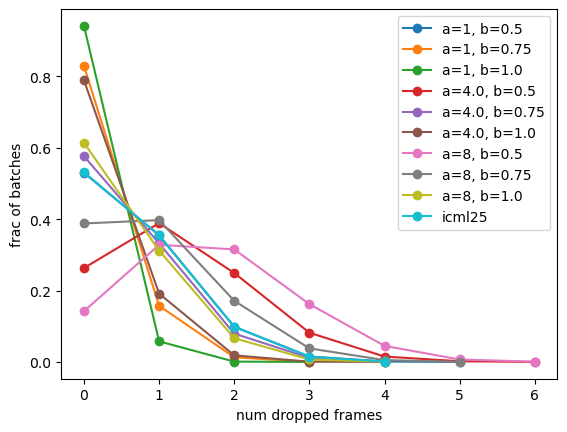

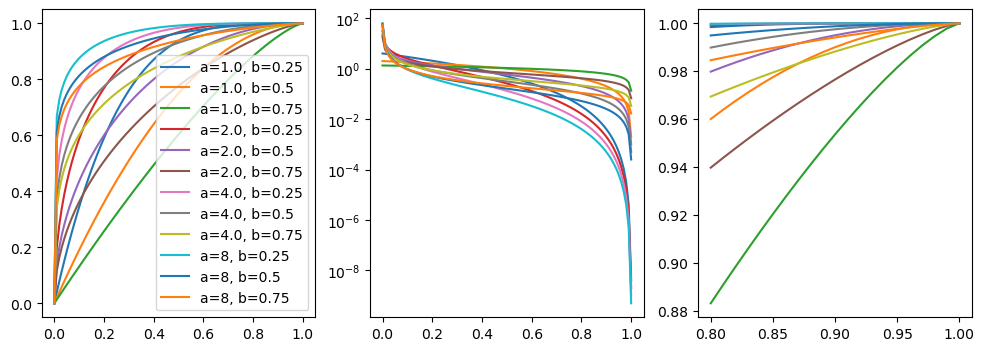

In [167]:
plt.figure(figsize=(12,4))
for a,b in product([1., 2., 4., 8], [0.25,0.5,0.75]):
    plt.subplot(131)
    plt.plot(ts, qk(ts, a, b), label=f"a={a}, b={b}")
    plt.subplot(132)
    plt.plot(ts, dk(ts.clamp(1e-3,1-1e-3), a, b))
    plt.yscale('log')
    plt.subplot(133)
    plt.plot(hs,qk(hs, a,b))
plt.subplot(131)
plt.legend()

In [18]:
print(f'rates min: {rates.min()}, max: {rates.max()}')
print(f'weights min: {weights.min()}, max: {weights.max()}')

rates min: 3.932324034394696e-06, max: 1.0
weights min: 0.004936606157571077, max: 1.5707963705062866


In [19]:
dm = DirichletMasking(config.world, alpha = 0.5, schedule='cosine')

AttributeError: 'DirichletMasking' object has no attribute 'cosine_schedule'

In [ ]:
m,w = dm(S=1, device='cpu')

In [ ]:
w

tensor([[[1.1926, 1.1926, 1.1926,  ..., 1.1926, 1.1926, 1.1926],
         [1.5699, 1.5699, 1.5699,  ..., 1.5699, 1.5699, 1.5699],
         [1.5697, 1.5697, 1.5697,  ..., 1.5697, 1.5697, 1.5697],
         ...,
         [1.4471, 1.4471, 1.4471,  ..., 1.4471, 1.4471, 1.4471],
         [0.2061, 0.2061, 0.2061,  ..., 0.2061, 0.2061, 0.2061],
         [1.4997, 1.4997, 1.4997,  ..., 1.4997, 1.4997, 1.4997]]])

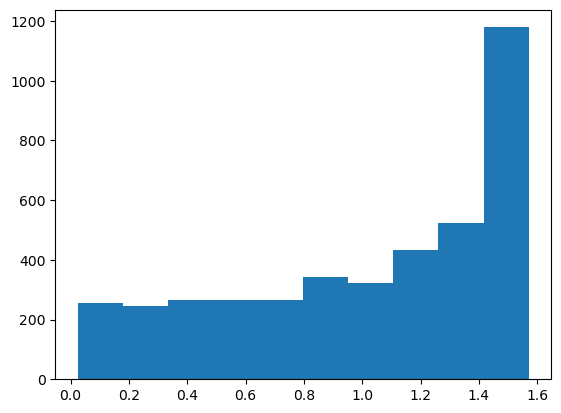

In [ ]:
for i in range(m.size(0)):
    plt.hist((w[i].mean(-1).flatten()))

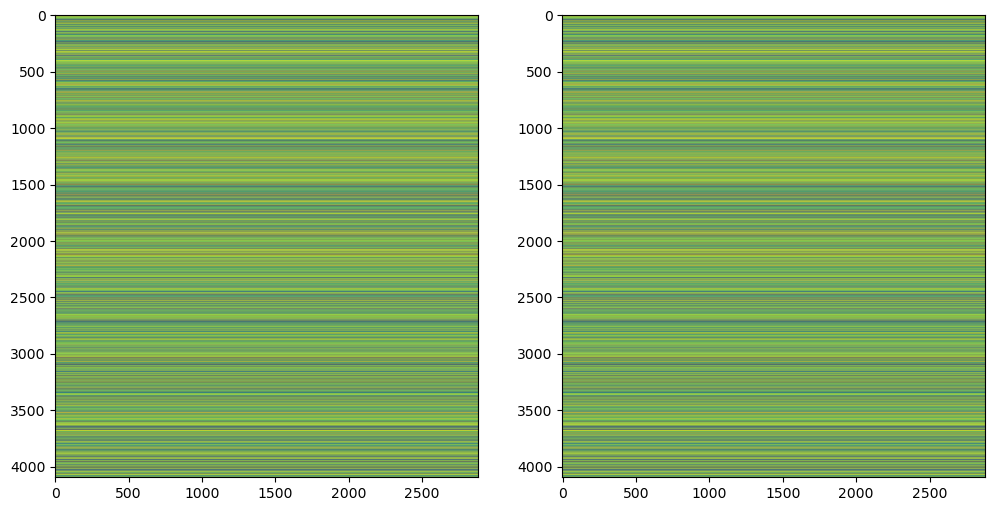

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12, 6))
axs[0].imshow(w[0], aspect='auto')
axs[1].imshow(w[-1], aspect='auto')

In [ ]:
64/2880

0.022222222222222223

In [ ]:
def create_model(cfg):
    return MaskedPredictor(cfg.model, cfg.world)

def create_optimizer(cfg, model):
    return torch.optim.AdamW(model.parameters(), lr = cfg.lr)

def create_scheduler(cfg, optimizer):
    schedulers = []
    milestones = []
    total = 0
    
    for sch_cfg in cfg.schedulers:  # list of dicts
        typ = sch_cfg["type"].lower()
        steps = sch_cfg["steps"]
        total += steps
        milestones.append(total)

        if typ == "linear":
            sched = torch.optim.lr_scheduler.LinearLR(
                optimizer,
                start_factor=sch_cfg.get("start_factor", 1.0),
                end_factor=sch_cfg.get("end_factor", 1.0),
                total_iters=steps
            )
        elif typ == "constant":
            sched = torch.optim.lr_scheduler.ConstantLR(
                optimizer,
                factor=sch_cfg.get("factor", 1.0),
                total_iters=steps
            )
        elif typ == "cosine":
            sched = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=steps,
                eta_min=sch_cfg.get("eta_min", 0.0)
            )
        else:
            raise ValueError(f"Unknown scheduler type: {typ}")

        schedulers.append(sched)
    
    print(total // 1373)
    # milestones exclude final stage
    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=schedulers,
        milestones=milestones[:-1],
    )
    return scheduler

In [ ]:
model = create_model(config)
optim = create_optimizer(config.trainer, model)


In [ ]:
lr = []

scheduler = create_scheduler(config.trainer, optim)
for i in range(500000):
    lr.append(scheduler.get_last_lr())
    scheduler.step()

109


/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/mnt/lustre/work/ludwig/jthuemmel54/miniforge3/envs/torch/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

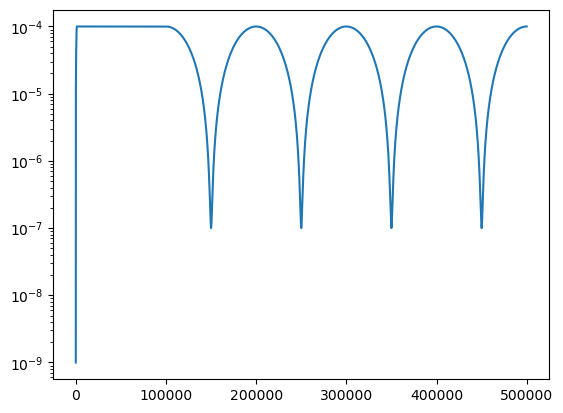

In [ ]:
plt.plot(lr)
plt.yscale("log")

In [ ]:
dm = DirichletMasking(world, alpha = 0.5, stratify=True, schedule= "cosine")
fm = ForecastMasking(world, 2)

In [ ]:
m, w = dm.sample_timesteps(4, "cpu")

In [ ]:
m.shape

torch.Size([4, 128, 2880])

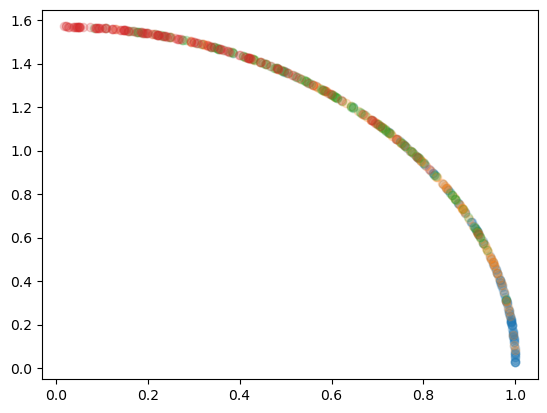

In [ ]:
for ms, ws in zip(m, w):
    plt.plot(ms[:, 0],ws[:, 0], "o", alpha=0.2)


In [ ]:
def setup_misc(self):
    # make sure we can distinguish between the two stages in wandb
    self.cfg.wb_tags = default(self.cfg.wb_tags, [])
    self.cfg.wb_tags.append(f"stage{self.current_stage}")

    # stage 1 doesn't need any further setup
    if self.current_stage == 1:
        return

    #stage 2 needs to load the pretrained weights
    pretrained_path = self.parse_stage1_id()
    self.load_pretrained(pretrained_path)

def parse_stage1_id(self):
    # load stage 1 model via its slurm id
    slurm_id_stage1 = default(self.cfg.stage1_id, str(self.slurm_id))
    if slurm_id_stage1.endswith("_stage1"):
        slurm_id_stage1 = slurm_id_stage1.strip("_stage1")
    self.cfg.stage1_id = slurm_id_stage1 # store the stage 1 id in the config for logging
    path = Path(self.cfg.model_dir) / f"{slurm_id_stage1}_stage1" / "ckpt.pth"
    return path

def create_job_name(self):
    stage_tag = f"stage{self.current_stage}"

    if exists(self.cfg.job_name):
        base_name = str(self.cfg.job_name).replace('/', '_')
        if base_name.endswith("_stage1"):
            base_name = base_name.strip("_stage1")
        if base_name.endswith("_stage2"):
            base_name = base_name.strip("_stage2")
    else:
        base_name = self.slurm_id

    self.job_name = f"{base_name}_{stage_tag}"
    self.cfg.job_name = self.job_name # enables resuming from config by using the job name

def set_current_stage(self, stage: int):
    self.current_stage = stage
    

In [ ]:
import torch
import einops

class Masking:
    def __init__(self, masking_cfg, world_cfg, optim_cfg, device, generator=None):
        self.masking = masking_cfg
        self.world = world_cfg
        self.optim_cfg = optim_cfg
        self.device = device
        self.generator = generator

    def get_timestep(self, timestep: str):
        if timestep == "uniform":
            t = self.single_timestep()
            lhs = 'b 1'
        elif timestep == "framewise":
            t = self.framewise_timestep()
            lhs = 'b t'
        elif timestep == 'history':
            t = self.history_timestep()
            lhs = 't'
        else:
            raise ValueError(f"Unknown timestep: {timestep}")
        return einops.repeat(t, f"{lhs} -> {self.world.flat_mask_pattern}", **self.world.token_sizes,b=self.optim_cfg.batch_size,)

    def get_schedule(self, t, schedule: str):
        if schedule == "cosine":
            rate = self.cosine_schedule(t)
            weight = self.cosine_weight(t, self.masking.eps)
        elif schedule == "arcsine":
            rate = self.arcsine_schedule(t)
            weight = self.arcsine_weight(t, self.masking.eps)
        elif schedule == "uniform":
            rate = (self.masking.rate_max - self.masking.rate_min) * t + self.masking.rate_min
            weight = torch.ones_like(rate)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")
        return rate, weight
    
    def get_mask(self, rate, mask: str):
        if mask == "bernoulli":
            visible = torch.bernoulli(rate, generator=self.generator).bool()
        elif mask == "topk":
            G = self.gumbel_noise((self.optim_cfg.batch_size, self.world.num_tokens))
            ks = self.k_from_rates(rate)
            if self.masking.alphas:
                G = G + self.dirichlet_joint()
            visible = self.binary_topk(G, ks=ks)
        else:
            raise ValueError(f"Unknown mask: {mask}")
        return visible

    def __call__(self,
                timestep: str = "uniform", 
                schedule: str = "cosine", 
                mask: str = "bernoulli"
                ):
        
        # pick timestep Float: (B, N, 1)
        t = self.get_timestep(timestep) 

        # pick schedule (elementwise) Float: (B, N, 1)
        rate, weight = self.get_schedule(t, schedule)

        # pick mask generator Boolean: (B, N, 1)
        visible = self.get_mask(rate, mask)

        return visible, weight

    # SAMPLING
    def uniform(self, shape: tuple):
        return torch.rand(shape, device=self.device, generator=self.generator)

    def gumbel_noise(self, shape: tuple):
        return -torch.log(-torch.log(self.uniform(shape)))

    # DIRICHLET
    def dirichlet_joint(self):
        D = einops.reduce(
            [self.dirichlet_marginal(ax).log() for ax in self.masking.alphas.keys()],
            "factors ... -> ...",
            "sum",
        )
        return D
    
    def dirichlet_marginal(self, ax: str):
        concentration = torch.full(
            (self.optim_cfg.batch_size, self.world.token_sizes[ax]),
            self.masking.alphas[ax],
            device=self.device,
        )
        probs = torch._sample_dirichlet(concentration, generator=self.generator)
        return einops.repeat(
            probs,
            f"b {ax} -> b {self.world.flat_token_pattern}",
            **self.world.token_sizes,
            b=self.optim_cfg.batch_size,
        )

    # TIMESTEPS
    def framewise_timestep(self):
        T = self.world.token_sizes["t"]
        B = self.optim_cfg.batch_size
        if self.masking.stratification:
            t = self.uniform((1, T))
            t = (t + torch.linspace(0, 1, B, device=t.device).view(-1, 1)) % 1
        else:
            t = self.uniform((B, T))
        f = self.masking.tail_frac
        t = torch.where(t > f, (t - f) / (1 - f), torch.zeros_like(t))
        return t

    def single_timestep(self):
        B = self.optim_cfg.batch_size
        if self.masking.stratification:
            t = self.uniform((1,))
            t = (t + torch.linspace(0, 1, B, device=t.device).view(-1, 1)) % 1
        else:
            t = self.uniform((B, 1))
        return t
    
    def history_timestep(self):
        t = torch.zeros((self.world.token_sizes["t"],), device=self.device)
        t[: self.world.tau] = 1.0
        return t
    
    # TOPK 
    def k_from_rates(self, rates):
        return (self.world.num_tokens * rates).long()

    def binary_topk(self, weights, ks):
        index = weights.argsort(dim=-1, descending=True)
        pos = torch.arange(weights.size(-1), device=weights.device)
        index = einops.rearrange(index, "b n -> b n 1")
        pos = einops.rearrange(pos, "n -> 1 n 1")
        binary = torch.zeros_like(index, dtype=torch.bool, device=self.device).scatter(1, index, ks > pos)
        return binary

    # SCHEDULES
    @staticmethod
    def arcsine_schedule(t: torch.Tensor):
        return 0.5 - 0.5 * torch.cos(torch.pi * t)

    @staticmethod
    def arcsine_weight(t: torch.Tensor, eps: float = 1e-3):
        t_adj = t * (1 - 2*eps) + eps  # maps t ∈ [0,1] → [eps, 1-eps]
        return 0.5 * torch.pi * torch.sin(torch.pi * t_adj)

    @staticmethod
    def cosine_schedule(t: torch.Tensor):
        return 1 - torch.cos(torch.pi * t / 2)

    @staticmethod
    def cosine_weight(t: torch.Tensor, eps: float = 1e-3):
        t_adj = t * (1 - 2*eps) + eps  # maps t ∈ [0,1] → [eps, 1-eps]
        return 0.5 * torch.pi * torch.sin(torch.pi * t_adj / 2)




In [ ]:
class MaskingStrategy(torch.nn.Module):
    def __init__(self, world, schedule: str):
        super().__init__()
        self.world = world
        self.schedule = getattr(self, f"{schedule}_schedule", default = self.linear_schedule)

    def sample_prior(self, S: int, B: int, device: torch.device, **kwargs) -> torch.FloatTensor:
        raise NotImplementedError
    
    def sample_timesteps(self, S: int, B: int, device: torch.device, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        raise NotImplementedError
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        raise NotImplementedError

    def forward(self, S: int, B: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> tuple[torch.BoolTensor, torch.FloatTensor]:
        prior = self.sample_prior(S, B, device, rng = rng, **kwargs)
        rates, weights = self.sample_timesteps(S, B, device, rng = rng, **kwargs)
        masks = self.sample_masks(prior, rates, **kwargs)
        return masks, weights

    # SELECT
    @staticmethod
    def binary_topk(prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        ks = (prior.size(-1) * rates).long()
        idx = prior.argsort(dim=-1, descending=True)
        rank = torch.arange(prior.size(-1), device=prior.device).expand_as(prior)
        mask = torch.zeros_like(prior, dtype=torch.bool, device=prior.device)
        mask.scatter_(dim = -1, index = idx, src= ks > rank) # True for top-k False otherwise
        return mask
    
    # SAMPLING
    @staticmethod
    def log_dirichlet(shape: tuple, alpha: float, device: torch.device,  eps: float = 1e-7, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        return torch.log(torch._sample_dirichlet(torch.full(shape, alpha, device=device), generator=rng) + eps)
    
    @staticmethod
    def gumbel(shape: tuple, device: torch.device, eps: float = 1e-7, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        return -torch.log(-torch.log(torch.rand(shape, device=device, generator=rng) + eps) + eps)
    
    # SCHEDULES
    @staticmethod
    def cosine_schedule(t: torch.FloatTensor, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        rates = 1 - torch.cos(torch.pi * t / 2)
        weights = 0.5 * torch.pi * torch.sin(torch.pi * t / 2)
        return rates, weights

    @staticmethod
    def linear_schedule(t: torch.FloatTensor, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        return t, torch.ones_like(t)
    
class DirichletMasking(MaskingStrategy):
    def __init__(self, world, alpha: float = 1.0, schedule: str = "cosine"):
        super().__init__(world, schedule = schedule)
        self.alpha = alpha

    def sample_prior(self, S: int, B: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> torch.FloatTensor:
        N, T = self.world.num_tokens, self.world.token_sizes["t"]
        log_dirichlet = self.log_dirichlet((S, B, T), self.alpha, device, generator=rng)
        gumbel_noise = self.gumbel((S, B, N), device, generator=rng)
        prior = einops.repeat(log_dirichlet, f"s b t -> s b {self.world.flat_token_pattern}", n=N) + gumbel_noise
        return prior

    def sample_timesteps(self, S: int, B: int, device: torch.device, rng: torch.Generator = None, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        t = torch.rand((S, B, 1), device=device, generator=rng)
        t = t.sort(dim=0).values  # sort timesteps for progressive masking
        rates, weights = self.schedule(t)
        return rates, weights
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        return self.binary_topk(prior, rates)
    

class ForecastMasking(MaskingStrategy):
    def __init__(self, world, schedule: str = "linear"):
        super().__init__(world, schedule = schedule)
        self.tau = self.world.tau

    def sample_prior(self, S: int, B: int, device: torch.device, **kwargs) -> torch.FloatTensor:
        prior = torch.arange(self.world.num_tokens, device=device).float()
        prior = einops.repeat(prior, "n -> s b n", s=S, b=B)
        return prior

    def sample_timesteps(self, S: int, B: int, device: torch.device, **kwargs) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        T = self.world.token_sizes["t"]
        start = (self.tau / T).float()
        t = torch.linspace(start, 1.0, steps=S, device=device)
        t = einops.repeat(t, "s -> s b ()", b=B)
        rates, weights = self.schedule(t) 
        return rates, weights
    
    def sample_masks(self, prior: torch.FloatTensor, rates: torch.FloatTensor, **kwargs) -> torch.BoolTensor:
        return self.binary_topk(prior, rates)
    

In [ ]:
world = WorldConfig(
    field_sizes = {'v': 4, 't': 36, 'h': 64, 'w': 120},
    patch_sizes={'vv': 4, 'tt': 6, 'hh': 4, 'ww': 4},
    batch_size=2,
    tau=2,
)

model = NetworkConfig(
    dim = 128,
    num_layers=4,
    num_compute_blocks=4,
    num_latents=256,
    dim_noise=32,
)


In [ ]:
tokens = torch.randn((world.batch_size, world.num_tokens, world.dim_tokens), device = ao_rin.device)

pred, mask, weights = ao_rin(tokens, num_steps = 2, num_ensemble = 4, prior = 'dirichlet', schedule = 'cosine')

tokens, pred = map(lambda x: einops.rearrange(x, 
                                              f'{world.flatland_pattern} ... -> {world.field_pattern} ...', 
                                              **world.token_sizes, **world.patch_sizes), 
                                              (tokens, pred)
                                              )
mask = einops.repeat(mask, f'b {world.flat_token_pattern} -> {world.field_pattern}', **world.token_sizes, **world.patch_sizes)
weights = einops.repeat(weights, f'b 1 -> {world.field_pattern}', **world.token_sizes, **world.patch_sizes)

In [ ]:
print(pred.shape, mask.shape, weights.shape)

torch.Size([2, 4, 36, 64, 120, 4]) torch.Size([2, 4, 36, 64, 120]) torch.Size([2, 4, 36, 64, 120])


In [ ]:
loss = f_kernel_crps(observation=tokens, ensemble=pred, fair=True)
masked_loss = (loss * weights)[mask].mean()

In [ ]:
loss.shape

torch.Size([2, 4, 36, 64, 120])

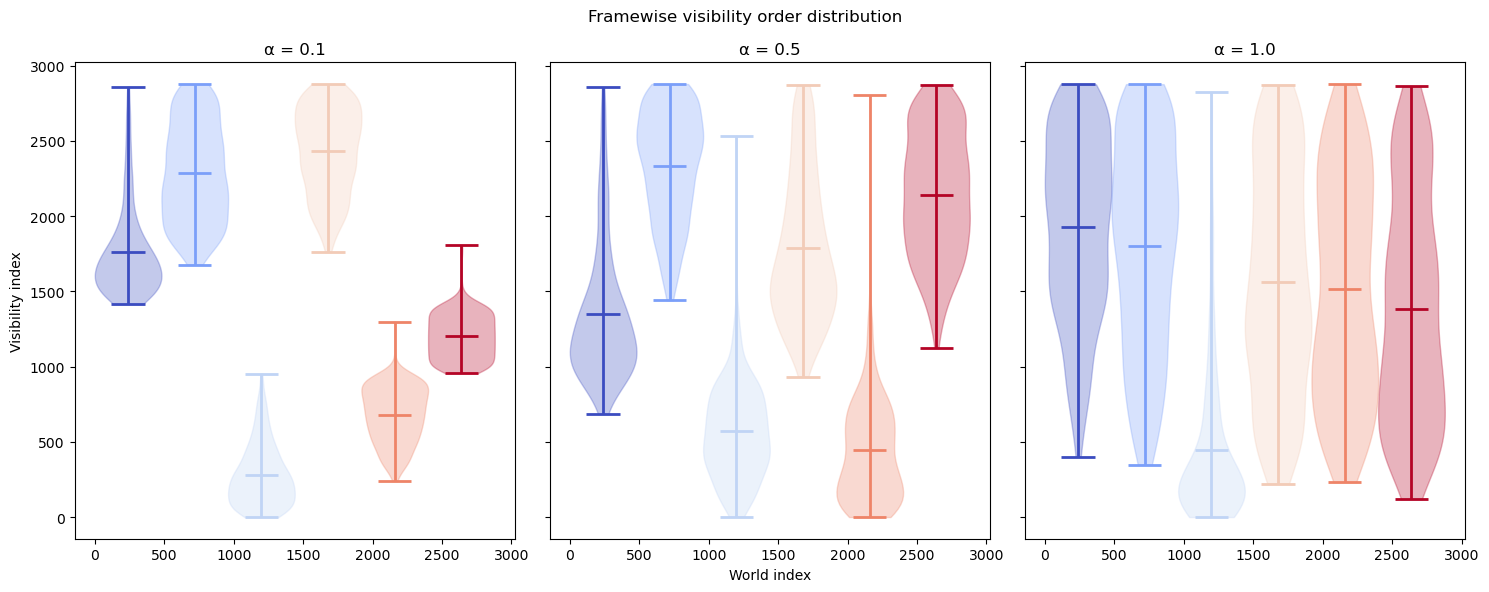

In [ ]:
T, S = 6, 480
alphas = [0.1, 0.5, 1.0]
colors = plt.cm.coolwarm(torch.linspace(0, 1, T))
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)
g = torch.rand((T * S)).log().neg().log().neg()

for i,alpha in enumerate(alphas):
    plt.sca(ax[i])
    a = torch.full((T,), alpha)
    ld = torch._sample_dirichlet(a).log().repeat_interleave(S, -1)
    sorted_vals, sorted_idx = torch.sort(ld + g, dim=-1)

    data = []
    positions = []
    for t in range(T):
        ids = torch.arange(t * S, (t + 1) * S)
        order_pos = (sorted_idx == ids.unsqueeze(1)).nonzero(as_tuple=False)[:, 1].numpy()
        data.append(order_pos)
        positions.append(ids.float().mean().item())  # center each violin at mean element index

    parts = plt.violinplot(data, positions=positions, widths=S, showextrema=True, showmeans=True)

    for pc, c in zip(parts['bodies'], colors):
        pc.set_facecolor(c)
        pc.set_edgecolor(c)

    # ensure extrema lines also match
    for key in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
        if key in parts:
            parts[key].set_color([colors[i] for i in range(T)])
            parts[key].set_linewidth(2.0)
    plt.title(f'α = {alpha}')
# label setup
ax[1].set_xlabel("World index")
ax[0].set_ylabel("Visibility index")
plt.suptitle('Framewise visibility order distribution')
plt.tight_layout()
plt.show()
